In [2]:
!pip install s3fs

In [33]:
import json

from matplotlib import pyplot as plt
import pandas as pd
import pickle
from s3fs.core import S3FileSystem
import numpy as np

In [8]:
MODEL_DIR = "mids-capstone-irrigation-detection/models"

In [9]:
s3_file = S3FileSystem()

# Models are model_name: description
models = {
    "simclr_finetune": "Fine tuned on 3% data",
    "simclr_finetune_ex": "Fine tuned on 3% data with Extended Labels",
}

In [10]:
def f_scores(scores):
    precision = scores[6]
    recall = scores[7]
    if precision + recall == 0.0:
        return [0.0, 0.0]
    f1 = (2 * precision * recall) / (precision + recall)
    beta = 0.5
    f05 = ((1 + beta) * precision * recall) / (beta * precision + recall)
    return [f1, f05]
    

In [23]:
def load_results():
    data = []
    for file in s3_file.listdir(MODEL_DIR):
        if file['type'] != 'directory':
            continue
        model_type = file["name"].split("/")[-1]
        if not model_type.startswith("simclr"):
            continue
        for result in s3_file.glob(file["name"]+"/*.json"):
            model_type = result.split("/")[-2]
            percent = result.split("/")[-1].split("_")[0]
            augmentations = result.split("/")[-1].split("_")[-1].split(".")[0]
            r = json.load(s3_file.open(result))
            score = [model_type, int(percent), augmentations] + r["score"] + f_scores(r["score"])
            data.append(score)
    df = pd.DataFrame(data)
    df.columns = ["model_type","split_percent","augmentations","loss","tp","fp","tn","fn","accuracy","precision","recall","auc","f1","f0.5"]
    df.split_percent = pd.to_numeric(df.split_percent, errors='coerce')
    return df

def plot_results(plot_df, title=None):
    _title = "Augmentations vs F1 Score"
    if title is not None:
        _title += f" - {title}"
    plot_df = plot_df.sort_values("f1")
    plot_df.plot(kind="barh", figsize=(15,12), rot=0, ylim=(0.0, 1.0), fontsize=12, x='augmentations', y='f1',color='b')
    
    plt.title(_title, fontsize=22)
    plt.legend(fontsize=12)
    plt.xlabel("F1 Score", fontsize=18)
    plt.ylabel("Augmentations", fontsize=18)

def display_results(df = None):
    if df is None:
        df = load_results()
    for model_type, desc in models.items():
        _df = df[df.model_type == model_type]
        
        line = "=" * len(desc) + "=="
        print(f"\n\n{line}\n {desc}\n{line}")
        display(_df.sort_values("split_percent"))

        plot_results(_df, desc)
        plt.savefig(f"{model_type}.png")

In [24]:
df = load_results()



 Fine tuned on 3% data


,model_type,split_percent,augmentations,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
0,simclr_finetune,3,"blur,brightness,contrast,gain,speckle",0.495520,1706.0,458.0,1575.0,325.0,0.807333,0.788355,0.839980,0.876507,0.813349,0.804844
22,simclr_finetune,3,"shift,blur",0.886173,1502.0,472.0,1560.0,530.0,0.753445,0.760892,0.739173,0.835232,0.749875,0.753512
23,simclr_finetune,3,"shift,brightness",0.413802,1717.0,412.0,1616.0,319.0,0.820128,0.806482,0.843320,0.897567,0.824490,0.818398
24,simclr_finetune,3,"shift,contrast",0.657598,1482.0,305.0,1725.0,552.0,0.789124,0.829323,0.728614,0.876310,0.775713,0.792796
25,simclr_finetune,3,"shift,flip",0.621533,1489.0,359.0,1675.0,541.0,0.778543,0.805736,0.733498,0.865170,0.767922,0.780126
26,simclr_finetune,3,"shift,gain",0.977125,1716.0,643.0,1389.0,316.0,0.764026,0.727427,0.844488,0.831317,0.781599,0.762667
27,simclr_finetune,3,"shift,zoom",0.747490,1652.0,528.0,1504.0,380.0,0.776575,0.757798,0.812992,0.855551,0.784425,0.775344
28,simclr_finetune,3,"speckle,blur",0.508529,1673.0,487.0,1546.0,358.0,0.792077,0.774537,0.823732,0.875605,0.798377,0.790269
21,simclr_finetune,3,"rotation,zoom",0.730757,1589.0,394.0,1638.0,443.0,0.794045,0.801311,0.781988,0.871581,0.791532,0.794765
29,simclr_finetune,3,"speckle,brightness",1.013925,1572.0,466.0,1566.0,460.0,0.772146,0.771344,0.773622,0.846040,0.772482,0.772102




 Fine tuned on 3% data with Extended Labels


,model_type,split_percent,augmentations,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
40,simclr_finetune_ex,3,"blur,brightness,contrast,gain,speckle",0.465496,3909.0,858.0,4631.0,1578.0,0.778061,0.820013,0.712411,0.873083,0.762434,0.780707
62,simclr_finetune_ex,3,"shift,blur",0.444731,4762.0,1398.0,4092.0,724.0,0.806669,0.773052,0.868028,0.873062,0.817792,0.802314
63,simclr_finetune_ex,3,"shift,brightness",0.454473,4305.0,1105.0,4377.0,1189.0,0.790999,0.795749,0.783582,0.871663,0.789618,0.791651
64,simclr_finetune_ex,3,"shift,contrast",0.450034,4648.0,1326.0,4163.0,839.0,0.802751,0.778038,0.847093,0.876756,0.811098,0.799771
65,simclr_finetune_ex,3,"shift,flip",0.459547,4139.0,1034.0,4454.0,1349.0,0.782890,0.800116,0.754191,0.866140,0.776475,0.784199
66,simclr_finetune_ex,3,"shift,gain",0.526358,4446.0,1284.0,4200.0,1046.0,0.787719,0.775916,0.809541,0.861212,0.792372,0.786810
67,simclr_finetune_ex,3,"shift,zoom",0.450377,4766.0,1446.0,4043.0,721.0,0.802569,0.767225,0.868599,0.870696,0.814771,0.798280
68,simclr_finetune_ex,3,"speckle,blur",0.465096,4192.0,1087.0,4404.0,1293.0,0.783163,0.794090,0.764266,0.865914,0.778893,0.783893
61,simclr_finetune_ex,3,"rotation,zoom",0.444360,4641.0,1341.0,4147.0,847.0,0.800656,0.775827,0.845663,0.871078,0.809241,0.797788
69,simclr_finetune_ex,3,"speckle,brightness",0.467478,4469.0,1267.0,4220.0,1020.0,0.791636,0.779114,0.814174,0.858788,0.796258,0.790460


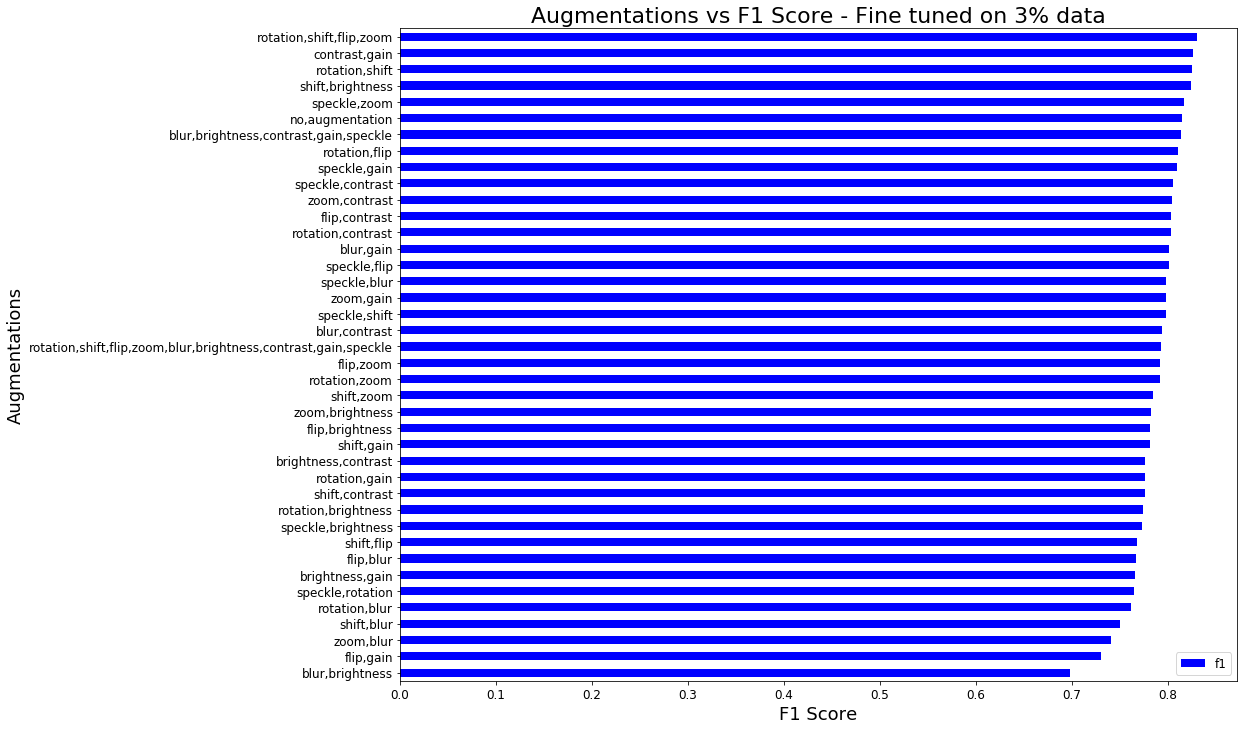

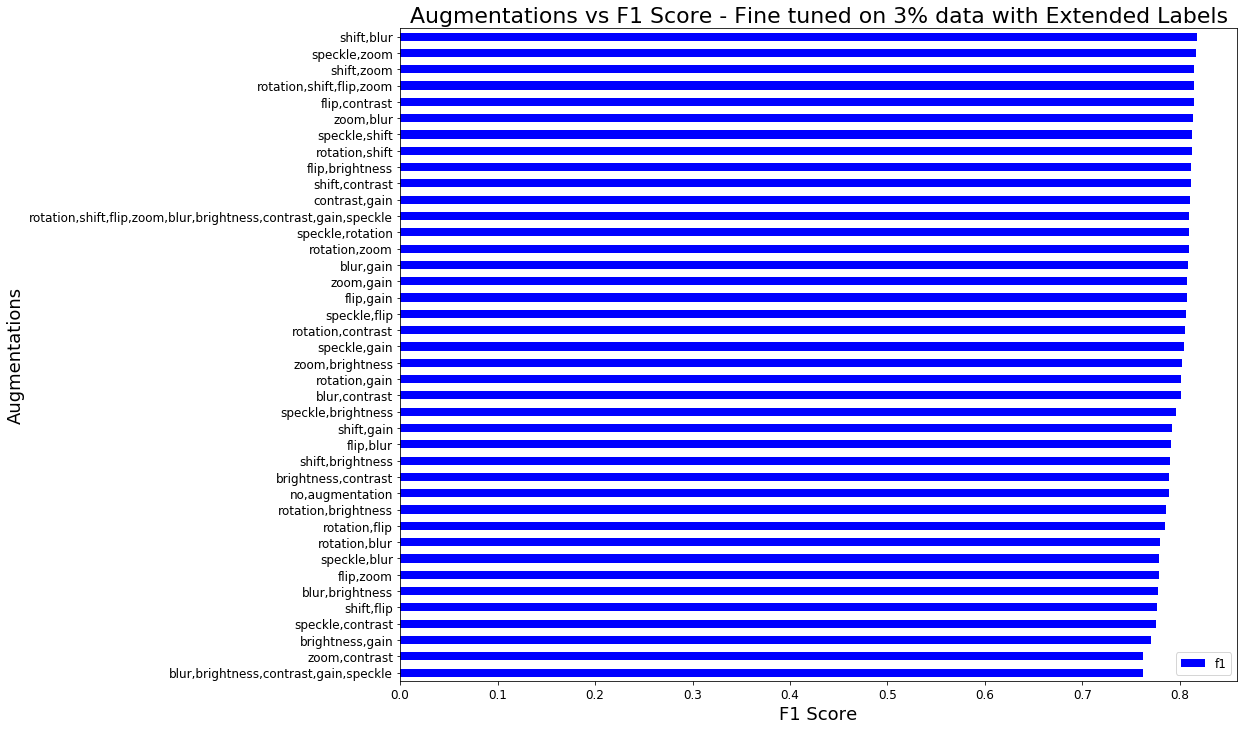

In [25]:
display_results(df)

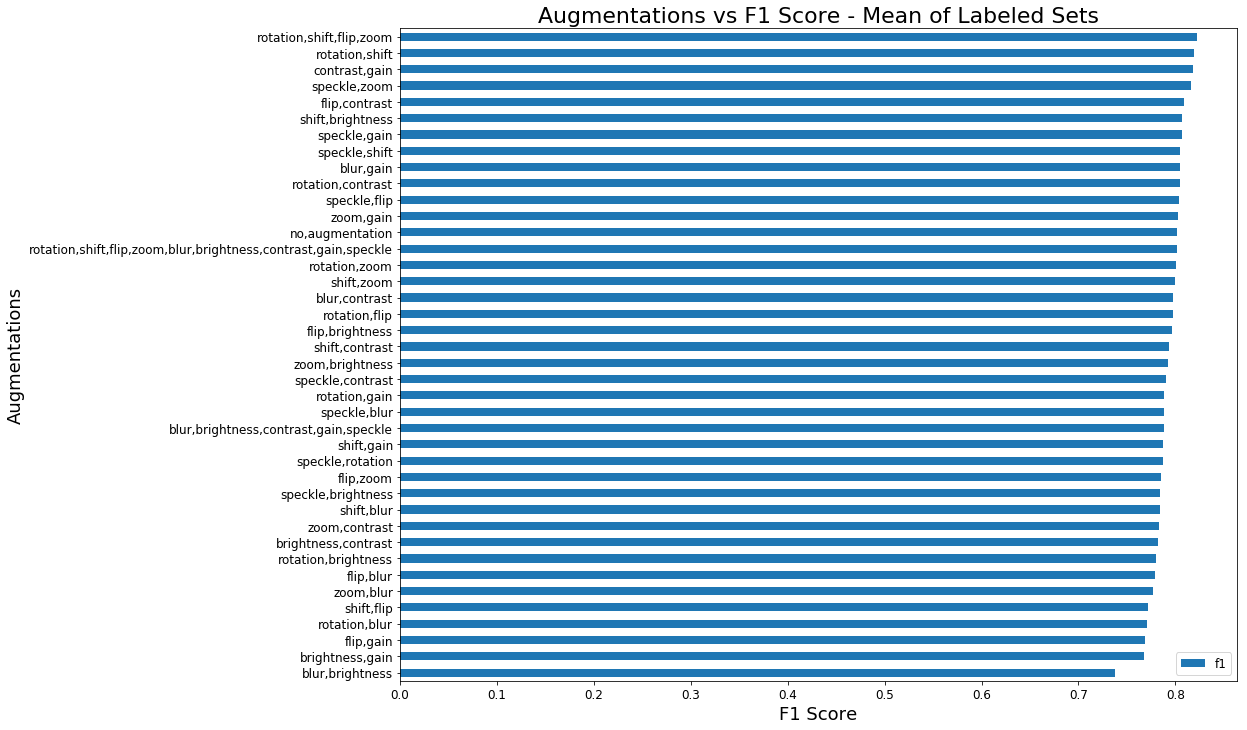

In [18]:
def plot_mean():
    mean_df = df[["augmentations", "f1"]].groupby(['augmentations']).mean().sort_values("f1")
    mean_df.plot(kind="barh", figsize=(15,12), rot=0, ylim=(0.0, 1.0), fontsize=12)
    plt.title("Augmentations vs F1 Score - Mean of Labeled Sets", fontsize=22)
    plt.legend(fontsize=12)
    plt.xlabel("F1 Score", fontsize=18)
    plt.ylabel("Augmentations", fontsize=18)
    
    return mean_df
mean_df = plot_mean()

In [19]:
mean_df

,f1
augmentations,
"blur,brightness",0.737781
"brightness,gain",0.767782
"flip,gain",0.768569
"rotation,blur",0.770475
"shift,flip",0.772198
"zoom,blur",0.777248
"flip,blur",0.778650
"rotation,brightness",0.780111
"brightness,contrast",0.782587


In [26]:
df.to_csv("results.csv")

In [78]:
df['augmentations'] = df['augmentations'].replace("no,augmentation","noaugmentation")

df[df['augmentations']=="noaugmentation"]

No handles with labels found to put in legend.


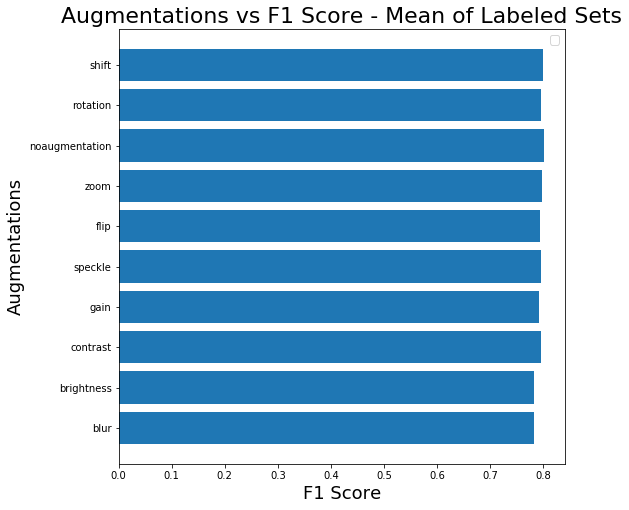

In [79]:
def plot_aug_mean():
    aug_dict = {}
    
    for index, row in df.iterrows() :
        for aug in row['augmentations'].split(',') :
            if aug not in aug_dict :
                aug_dict[aug] = []
            aug_dict[aug].append( row['f1'])
    
    for key in aug_dict.keys() :
        scores = aug_dict[key]
        aug_dict[key] = np.mean(scores)
        
        
    names = list(aug_dict.keys())
    values = list(aug_dict.values())
    
    
    #tick_label does the some work as plt.xticks()
    plt.figure(figsize=(8,8))
    plt.barh(range(len(aug_dict)),values,tick_label=names)
            
    plt.title("Augmentations vs F1 Score - Mean of Labeled Sets", fontsize=22)
    plt.legend(fontsize=12)
    plt.xlabel("F1 Score", fontsize=18)
    plt.ylabel("Augmentations", fontsize=18)
    
    return aug_dict
aug_mean = plot_aug_mean()

In [80]:
print(aug_mean)

{'blur': 0.7827647589760163, 'brightness': 0.7837644890513714, 'contrast': 0.7967685340577033, 'gain': 0.7933415836140109, 'speckle': 0.7971218320425129, 'flip': 0.7934449417861529, 'zoom': 0.798142548144735, 'noaugmentation': 0.8015623636515674, 'rotation': 0.7970922114467058, 'shift': 0.7990918152179133}


No handles with labels found to put in legend.


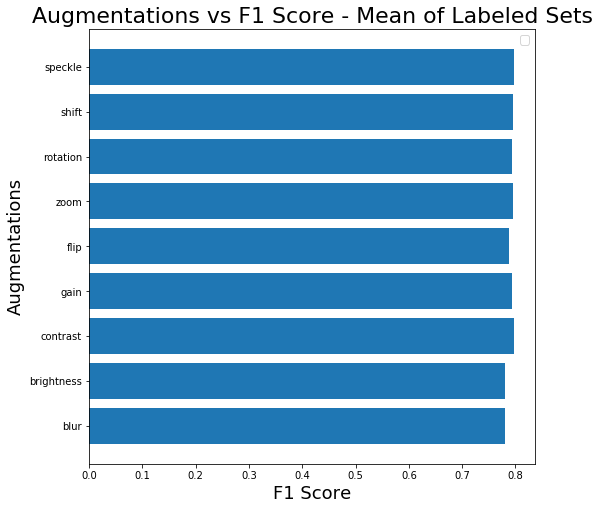

In [84]:
def plot_aug_noFF_mean():
    aug_dict = {}
    
    for index, row in df[~df['augmentations'] \
                         .isin(['noaugmentation', \
                               'rotation,shift,flip,zoom,blur,brightness,contrast,gain,speckle', \
                               'rotation,shift,flip,zoom', \
                               'blur,brightness,contrast,gain,speckle', \
                               ])].iterrows() :
        for aug in row['augmentations'].split(',') :
            if aug not in aug_dict :
                aug_dict[aug] = []
            aug_dict[aug].append( row['f1'])
    
    for key in aug_dict.keys() :
        scores = aug_dict[key]
        aug_dict[key] = np.mean(scores)
        
        
    names = list(aug_dict.keys())
    values = list(aug_dict.values())
    
    
    #tick_label does the some work as plt.xticks()
    plt.figure(figsize=(8,8))
    plt.barh(range(len(aug_dict)),values,tick_label=names)
            
    plt.title("Augmentations vs F1 Score - Mean of Labeled Sets", fontsize=22)
    plt.legend(fontsize=12)
    plt.xlabel("F1 Score", fontsize=18)
    plt.ylabel("Augmentations", fontsize=18)
    
    return aug_dict
aug_noFF_mean = plot_aug_noFF_mean()

In [85]:
aug_noFF_mean

{'blur': 0.7798033580909397,
 'brightness': 0.7810530206851335,
 'contrast': 0.7973080769430485,
 'gain': 0.7930243888884327,
 'flip': 0.788814097570282,
 'zoom': 0.7946861055185097,
 'rotation': 0.7933731846459734,
 'shift': 0.7958726893599828,
 'speckle': 0.7977496994240605}